In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os


class VSDDataset:
    def __init__(self, dataDir: str):
        self.data_dir = dataDir
        self.dataframe = self.build_dataframe(*self.dataPaths())

        split_result = self.train_test_split(self.dataframe)
        self.train, self.valid, self.test = split_result

    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

    def build_dataframe(self, files: list, labels: list):
        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        df = pd.concat([Fseries, Lseries], axis=1)

        return df

    def train_test_split(self, data: pd.DataFrame):
        df = data.copy()
        y = df['labels']

        train_data, dummy_data = train_test_split(
            df, train_size=0.8, stratify=y, shuffle=True, random_state=None
        )

        strat = dummy_data['labels']
        valid_data, test_data = train_test_split(
            dummy_data, train_size=0.5, stratify=strat,
            shuffle=True, random_state=None
        )

        return train_data, valid_data, test_data

In [2]:
folder_path = os.getcwd()
ws_path = os.path.dirname(folder_path)
data_dir = ws_path + '/preproDataset'

dataObj = VSDDataset(data_dir)
df = dataObj.dataframe
df.tail()

,filepaths,labels
669,/mnt/e/Kuliah/MBKM/CV Advance With Unity/Tugas...,vsd
670,/mnt/e/Kuliah/MBKM/CV Advance With Unity/Tugas...,vsd
671,/mnt/e/Kuliah/MBKM/CV Advance With Unity/Tugas...,vsd
672,/mnt/e/Kuliah/MBKM/CV Advance With Unity/Tugas...,vsd
673,/mnt/e/Kuliah/MBKM/CV Advance With Unity/Tugas...,vsd


In [3]:
train_df = dataObj.train
valid_df = dataObj.valid
test_df = dataObj.test

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def augment_data(train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'


    train_datagen = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5, 1.5]
    )

    valid_test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        color_mode=color,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical'
    )

    print("Shape of augmented training images:", train_generator.image_shape)

    valid_generator = valid_test_datagen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        color_mode=color,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical'
    )

    print("Shape of validation images:", valid_generator.image_shape)

    test_generator = valid_test_datagen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        color_mode=color,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical'
    )

    print("Shape of test images:", test_generator.image_shape)

    return train_generator, valid_generator, test_generator


augment_result = augment_data(train_df, valid_df, test_df)
train_augmented, valid_augmented, test_augmented = augment_result

2025-06-25 19:40:50.332330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750855250.486441    1546 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750855250.529249    1546 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750855250.855268    1546 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750855250.855332    1546 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750855250.855334    1546 computation_placer.cc:177] computation placer alr

Found 539 validated image filenames belonging to 2 classes.
Shape of augmented training images: (256, 256, 3)
Found 67 validated image filenames belonging to 2 classes.
Shape of validation images: (256, 256, 3)
Found 68 validated image filenames belonging to 2 classes.
Shape of test images: (256, 256, 3)


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf


classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(
    weights='imagenet', include_top=False, input_shape=(256, 256, 3)
)

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(
    512, activation='relu' , kernel_regularizer = regularizers.l2(0.01)
)(x)

predictions = Dense(
    classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01)
    )(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']
)
model.summary()

I0000 00:00:1750855263.938585    1546 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1989 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        960 │ block1a_se_excit

 Total params: 11,571,505 (44.14 MB)

 Trainable params: 787,970 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_efficientnetb3_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


history = model.fit(
    train_augmented,
    epochs=25,
    validation_data=valid_augmented,
    callbacks=callbacks
)

/home/daffin_tw/python-environments/tf219/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1750855314.569368    1683 service.cc:152] XLA service 0x7a62d0001e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750855314.569437    1683 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-06-25 19:41:55.395862: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750855319.382733    1683 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750855349.110663    1683 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6089 - loss: 7.2362
Epoch 1: val_accuracy improved from -inf to 0.65672, saving model to best_efficientnetb3_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.6108 - loss: 7.1969 - val_accuracy: 0.6567 - val_loss: 3.7435 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7264 - loss: 3.0568
Epoch 2: val_accuracy improved from 0.65672 to 0.67164, saving model to best_efficientnetb3_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 459ms/step - accuracy: 0.7280 - loss: 3.0429 - val_accuracy: 0.6716 - val_loss: 2.0461 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.8321 - loss: 1.6639
Epoch 3: val_accuracy improved from 0.67164 to 0.77612, saving model to best_efficientnetb3_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 415ms/step - accuracy: 0.8323 - loss: 1.6592 - val_accuracy: 0.7761 - val_loss: 1.3330 - learning_rate: 0.0010
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8556 - loss: 1.1329
Epoch 4: val_accuracy did not improve from 0.77612
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.8552 - loss: 1.1320 - val_accuracy: 0.6418 - val_loss: 1.3059 - learning_rate: 0.0010
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8531 - loss: 0.9102
Epoch 5: val_accuracy did not improve from 0.77612
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 344ms/step - accuracy: 0.8535 - loss: 0.9083 - val_accuracy: 0.7761 - val_loss: 0.8655 - learning_rate: 0.0010
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8429 - loss: 0.7944
Epoch 6: val_accuracy improved from 0.77612 to 0.80597, saving model to best_efficientnetb3_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - accuracy: 0.8433 - loss: 0.7930 - val_accuracy: 0.8060 - val_loss: 0.7729 - learning_rate: 0.0010
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8501 - loss: 0.6921
Epoch 7: val_accuracy did not improve from 0.80597
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step - accuracy: 0.8511 - loss: 0.6906 - val_accuracy: 0.7761 - val_loss: 0.7150 - learning_rate: 0.0010
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8979 - loss: 0.5738
Epoch 8: val_accuracy improved from 0.80597 to 0.86567, saving model to best_efficientnetb3_model.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 399ms/step - accuracy: 0.8974 - loss: 0.5743 - val_accuracy: 0.8657 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 9/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8622 - loss: 0.5646
Epoch 9: val_accuracy did not improve from 0.86567
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.8620 - loss: 0.5642 - val_accuracy: 0.7761 - val_loss: 0.6208 - learning_rate: 0.0010
Epoch 10/25
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8642 - loss: 0.5282
Epoch 10: val_accuracy did not improve from 0.86567
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step - accuracy: 0.8646 - loss: 0.5266 - val_accuracy: 0.8358 - val_loss: 0.5505 - learning_rate: 0.0010
Epoch 11/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8865 - loss: 0.4750
Epoch 11: val_accuracy did not improve from 0.86567
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - accuracy: 0.8861 - loss: 0.4754 - val_accuracy: 0.8060 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 12/25
34/34

34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 480ms/step - accuracy: 0.8385 - loss: 0.5290 - val_accuracy: 0.9104 - val_loss: 0.4431 - learning_rate: 2.0000e-04
Epoch 17/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9114 - loss: 0.3956
Epoch 17: val_accuracy did not improve from 0.91045
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 288ms/step - accuracy: 0.9113 - loss: 0.3956 - val_accuracy: 0.8955 - val_loss: 0.4647 - learning_rate: 2.0000e-04
Epoch 18/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9245 - loss: 0.3997
Epoch 18: val_accuracy did not improve from 0.91045
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 330ms/step - accuracy: 0.9242 - loss: 0.3998 - val_accuracy: 0.8955 - val_loss: 0.4709 - learning_rate: 2.0000e-04
Epoch 19/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9149 - loss: 0.3875
Epoch 19: val_accuracy did not improve from 0.91045
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.9150 - loss: 0.3873 - val_accuracy: 0.8806 - val_loss: 0.4397 - learning_rate: 2.0000e-04

Training Accuracy: 0.9276437759399414
Validation Accuracy: 0.89552241563797


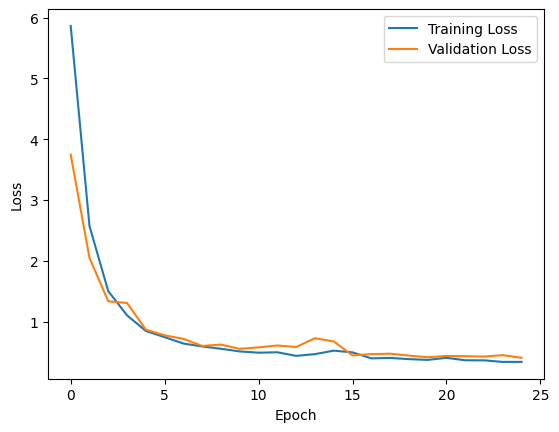

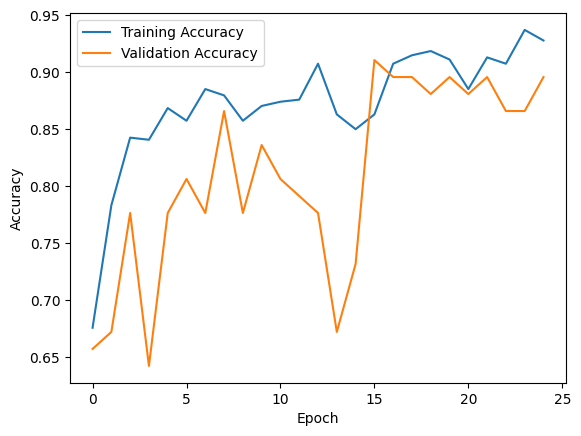

In [7]:
import matplotlib.pyplot as plt


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
import json


# Get the dictionary containing each metric and the loss for each epoch
history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('model_training_history.json', 'w'))

# history_dict = json.load(open(your_history_path, 'r'))

/home/daffin_tw/python-environments/tf219/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step 
              precision    recall  f1-score   support

      normal       0.94      0.85      0.89        34
         vsd       0.86      0.94      0.90        34

    accuracy                           0.90        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.90      0.90      0.90        68



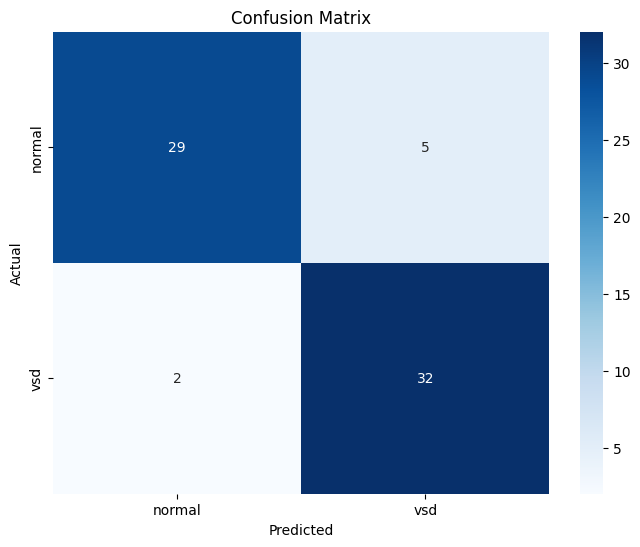

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np


def evaluate_model(model, validation_generator):
    y_true = validation_generator.classes
    class_labels = list(validation_generator.class_indices.keys())

    # Prediksi
    y_pred_probs = model.predict(validation_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)  # jika outputnya one-hot atau softmax

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


evaluate_model(model, test_augmented)

In [ ]:
from tensorflow.keras.models import load_model


model = load_model('best_efficientnetb3_model.h5')